# Aphantasia Drawing Analysis
This analysis uses the [Aphantasia Drawing Dataset](https://huggingface.co/datasets/jmc255/aphantasia_drawing_dataset) on Hugging Face to try and find any patterns in the drawings between individuals with aphantasia (inability to form visual images) and without. The data includes drawings of a kitchen, living room, and bedroom, each drawn from memory (`memory`) and while looking at the actual image (`perception`). For a full description of the dataset you can visit the link above.

This analysis is done by using OpenAI's ViT CLIP model for feature extraction and cosine similarity to measure how good a drawing is to the actual images from the feature embeddings.

Using these similarity scores I see if I can classify aphantasia and also do an ANOVA to see if I can mimic the results of the paper the data was collected from.

#### Load Packages and Dataset

In [ ]:
!pip install -q datasets
from datasets import load_dataset
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Hugging Face Dataset
dataset = load_dataset("jmc255/aphantasia_drawing_dataset", trust_remote_code=True)

In [ ]:
actual_imgs = dataset["train"]["image"][0] # Dictionary of actual images

#### Load ViT CLIP Model and Calculate Similarites
The [ViT CLIP model](https://huggingface.co/openai/clip-vit-base-patch32) from OpenAI was originally trained on image-text pairs and can be used for zero-shot image classification. In my case I am using it as a feature extractor to get embedding vectors from the drawings and actual images. From the embeddings I calculate the cosine similarity between the drawings and actual images to get a similarity score.

Cosine similarity basically measures how close 2 vectors are in a vector space:

$\cos(\theta) = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|}$



In [ ]:
import torch
from transformers import CLIPImageProcessor, CLIPModel, CLIPProcessor

model_ID = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_ID)
preprocess = CLIPImageProcessor.from_pretrained(model_ID)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

In [ ]:
def preprocess_image(image):
  image = image.convert('L') # Convert to grayscale
  image = preprocess(image, return_tensors="pt") #preprocess image
  return image

In [ ]:
# Compute simiarity score between drawings and actual images
def compute_similarity(img1,img2):
  img1_preprocessed = preprocess_image(img1)['pixel_values']
  img2_preprocessed  = preprocess_image(img2)['pixel_values']
  with torch.no_grad():
    embedding_a = model.get_image_features(img1_preprocessed)
    embedding_b = model.get_image_features(img2_preprocessed)
  similarity_score = torch.nn.functional.cosine_similarity(embedding_a, embedding_b)
  return similarity_score.item()

In [ ]:
# Extract Similarity Scores from all the drawings
def get_similarities(subject_dict):
  drawings = subject_dict["drawings"]
  similarities = {
      "kitchen": [],
      "bedroom": [],
      'livingroom': []
  }
  for room in ["kitchen","livingroom","bedroom"]:
    mod_similarities = {"memory": np.nan, "perception": np.nan}

    for t in ["memory", "perception"]:
      if drawings[room][t]:
        similarity = compute_similarity(drawings[room][t], actual_imgs[room])
        mod_similarities[t] = similarity

    similarities[room] = mod_similarities
  return {
      'subject_id': subject_dict["subject_id"],
      'treatment': subject_dict["treatment"],
      'drawings': subject_dict["drawings"],
      'similarity': similarities
  }

In [ ]:
new_data = []
for row in iter(dataset["train"]):
  new_data.append(get_similarities(row))

similarities_df = pd.json_normalize(new_data)
rename_mapping = {
    "similarity.kitchen.memory": "kitchen_mem",
    "similarity.kitchen.perception": 'kitchen_percep',
    "similarity.bedroom.memory": 'bedroom_mem',
    "similarity.bedroom.perception": 'bedroom_percep',
    "similarity.livingroom.memory": 'livingroom_mem',
    "similarity.livingroom.perception": 'livingroom_percep',
    'drawings.kitchen.perception': 'kitchen_percep_drawing',
    'drawings.kitchen.memory': 'kitchen_mem_drawing',
    'drawings.livingroom.perception': 'livingroom_percep_drawing',
    'drawings.livingroom.memory': 'livingroom_mem_drawing',
    'drawings.bedroom.perception': 'bedroom_percep_drawing',
    'drawings.bedroom.memory': 'bedroom_mem_drawing'
}
similarities_df.rename(columns = rename_mapping, inplace = True)
all_cols = [col for col in similarities_df.columns if "draw" not in col]
all_cols = all_cols[2:]

#### Summary Statistics

Overall the mean for perception drawings between the rooms are higher than the mean for memory drawings which makes sense since the perception drawings were done while looking at the image.



In [ ]:
similarities_df[[
    'kitchen_mem', 'kitchen_percep',
    'bedroom_mem',	'bedroom_percep',
    'livingroom_mem',	'livingroom_percep'
]].describe().round(3)

kitchen_mem  kitchen_percep  bedroom_mem  bedroom_percep  \
count      113.000         111.000      110.000         113.000   
mean         0.559           0.585        0.588           0.639   
std          0.040           0.036        0.054           0.054   
min          0.450           0.517        0.445           0.474   
25%          0.532           0.558        0.561           0.610   
50%          0.560           0.583        0.590           0.644   
75%          0.581           0.610        0.617           0.669   
max          0.672           0.666        0.759           0.752   

       livingroom_mem  livingroom_percep  
count         111.000            112.000  
mean            0.613              0.676  
std             0.053              0.060  
min             0.461              0.454  
25%             0.574              0.643  
50%             0.618              0.672  
75%             0.649              0.721  
max             0.724              0.835

##### Correlation Matrix

In [ ]:
similarities_df[[
    'kitchen_mem', 'kitchen_percep', 'bedroom_mem',
    'bedroom_percep', 'livingroom_mem', 'livingroom_percep'
]].corr().round(3)

kitchen_mem  kitchen_percep  bedroom_mem  bedroom_percep  \
kitchen_mem              1.000           0.264        0.506           0.275   
kitchen_percep           0.264           1.000        0.145           0.244   
bedroom_mem              0.506           0.145        1.000           0.187   
bedroom_percep           0.275           0.244        0.187           1.000   
livingroom_mem           0.420           0.077        0.424           0.087   
livingroom_percep        0.321           0.269        0.194           0.454   

                   livingroom_mem  livingroom_percep  
kitchen_mem                 0.420              0.321  
kitchen_percep              0.077              0.269  
bedroom_mem                 0.424              0.194  
bedroom_percep              0.087              0.454  
livingroom_mem              1.000              0.231  
livingroom_percep           0.231              1.000

##### Summary Statistics by Group
The perception drawings show no noticeable difference in the average similarity score for any of the drawings between the 2 groups. However the similarity scores for the control group with the memory drawings are higher across all rooms.

In [ ]:
summary_percep = similarities_df.groupby('treatment').agg({"kitchen_percep":['mean'],"livingroom_percep":['mean'],"bedroom_percep":['mean']}).round(3)
summary_mem = similarities_df.groupby('treatment').agg({"kitchen_mem":['mean'],"livingroom_mem":['mean'],"bedroom_mem":['mean']}).round(3)
summary_percep.columns = ['_'.join(col).strip() for col in summary_percep.columns.values]
summary_mem.columns = ['_'.join(col).strip() for col in summary_mem.columns.values]

In [ ]:
# Perception Similarity Scores between Aphantasia and Control
print(summary_percep)

            kitchen_percep_mean  livingroom_percep_mean  bedroom_percep_mean
treatment                                                                   
Aphantasia                0.590                   0.670                0.638
Control                   0.578                   0.684                0.640


In [ ]:
# Memory Similarity Scores between Aphantasia and Control
print(summary_mem)

            kitchen_mem_mean  livingroom_mem_mean  bedroom_mem_mean
treatment                                                          
Aphantasia             0.551                0.605             0.573
Control                0.568                0.622             0.606


##### Plots
The histograms for kitchen  (kitchen_percep) drawings and living room memory (livingroom_mem) drawings stand out between the 2 groups. Aphantasia is shifted to the right of control for kitchen perception and is shifted to the the left for living room memory.

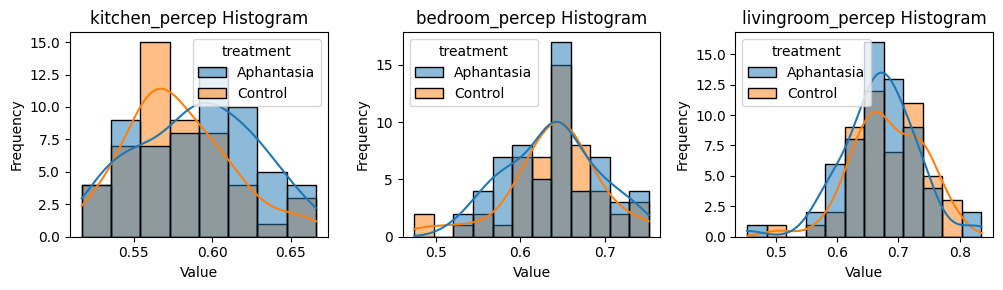

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for i, room in enumerate(["kitchen_percep", "bedroom_percep", "livingroom_percep"]):
    sns.histplot(data=similarities_df, x=room, hue="treatment", ax=axes[i], kde=True)
    axes[i].set_title(f"{room} Histogram")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

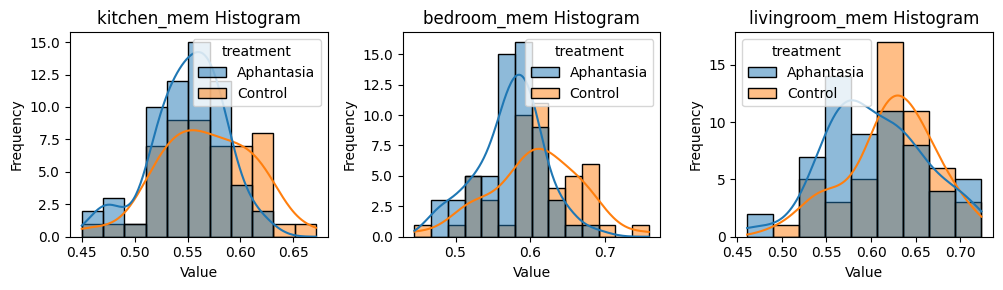

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for i, room in enumerate(["kitchen_mem", "bedroom_mem", "livingroom_mem"]):
    sns.histplot(data=similarities_df, x=room, hue="treatment", ax=axes[i], kde=True)
    axes[i].set_title(f"{room} Histogram")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [ ]:
fig = px.scatter_3d(similarities_df, x='kitchen_mem', y='livingroom_mem', z='bedroom_mem', color='treatment',
                    color_discrete_map={'Aphantasia': 'red', 'Control': 'blue'},
                    title='Memory Similarities by Group', width = 600, height = 500)

fig.update_layout(scene=dict(xaxis_title='Kitchen', yaxis_title='Living Room', zaxis_title='Bedroom'))
fig.show()

### Best and Worst Drawings

In [ ]:
def get_top_bottom(column, top = True):
  if top:
    r = "Top"
  else:
    r = "Bottom"
  room, typ = column.split('_')
  draw_col = column + '_drawing'
  sel_cols = ['treatment',draw_col, column]
  top_bottom_df = similarities_df.sort_values(by = column, ascending = not top).head(3)
  top_bottom_df = top_bottom_df[sel_cols].set_index(np.array(range(3))+1)
  top_bottom_df = top_bottom_df.rename(columns = {draw_col:'Drawing', column: 'Similarity'})
  top_bottom_df['Similarity'] = top_bottom_df['Similarity'].apply(lambda x: round(x*100,2))
  top_bottom_dict = top_bottom_df.to_dict(orient = 'index')

  fig, axes = plt.subplots(1, 4, figsize=(7, 3))
  ranking = {1: 'First', 2: 'Second', 3: 'Third'}
  for i in range(3):
    axes[i+1].imshow(np.array(top_bottom_dict[i+1]['Drawing']))
    axes[i+1].axis('off')
    axes[i+1].set_title(f"{ranking[i+1]}: {top_bottom_dict[i+1]['Similarity']}")
  axes[0].imshow(actual_imgs[room])
  axes[0].axis('off')
  axes[0].set_title(f'Actual {room}')
  plt.subplots_adjust(left=0.1)
  fig.suptitle(f"{r} Drawings of {room} for {typ}", fontsize=12, color='black')
  path = column + "_" + r + ".png"
  plt.savefig(path)
  plt.close()

In [ ]:
from itertools import product

for col, typ in product(all_cols,[True,False]):
  get_top_bottom(col, top = typ)

### **Living Room**
Perception | Memory
--- | ---
![img](https://drive.google.com/uc?id=1-d_t_7Hp2_4KPi6oB-UP8Ot9PRIYD5mG) | ![img](https://drive.google.com/uc?id=1-DMyAxhgXnj27GTH1VLQZ_vH-Yrv8JtN)
![img](https://drive.google.com/uc?id=1-ReAvAojCotmBJ8btlxHOeG7PaxGloDg) | ![img](https://drive.google.com/uc?id=1-DfrMJW_1uBeUGfPLq2FBP8UheYlDYXp)



### **Bedroom**
Perception | Memory
--- | ---
![img](https://drive.google.com/uc?id=1--6B7I0ZNA1qw6y4nC9W9cM08YLuv3M-) | ![img](https://drive.google.com/uc?id=1-DMyAxhgXnj27GTH1VLQZ_vH-Yrv8JtN)
![img](https://drive.google.com/uc?id=1-MgzKZiKjQO-K-W20VVJwr2wOljE7Zp2) | ![img](https://drive.google.com/uc?id=1-477dfBgoU7lcc9AYlaiQUEMRJzqfjs3)

### **Kitchen**
Perception | Memory
--- | ---
![img](https://drive.google.com/uc?id=17RqgTTSnJxA3-RrBnuhM9jXRCDoPnVyZ) | ![img](https://drive.google.com/uc?id=1U1n277EBxfwsOfWrFMLpeC4smOg1w21I)
![img](https://drive.google.com/uc?id=1lfJPc82bNtSx_03kS4XZzEoNLxZ89T6U) | ![img](https://drive.google.com/uc?id=1Cw_y7VymfmAClY6ynBHBeC68_bSaxcxL)

The top and bottom drawings from the similarity scores seem to be pretty accurate. Though there are some drawings that I thought shouldn't have been a top drawing or a bottom drawing.

The best overall drawing came from the living room perception drawings with a similarity of 83.52.

When experimenting with the preprocessing of the images I found that turning the images to grayscale and then back to RGB gave the most accurate scores among the drawings. This way drawings without color aren't pentalized. However there's a tradeoff as a few drawings had low similarity when color was taken away.

### Outliers
There are a few drawings that were given generous similarity scores even though they looked nothing like the picture or were just words.

For the analysis I decided to keep the observations that had these type of drawings because they had other drawings that were of use. Also The dataset only has around 115 rows so there's not much room to throw away data. This is also why I imputed missing similarity scores with the mean of that column.

Text(0.5, 0.98, 'Outliers')

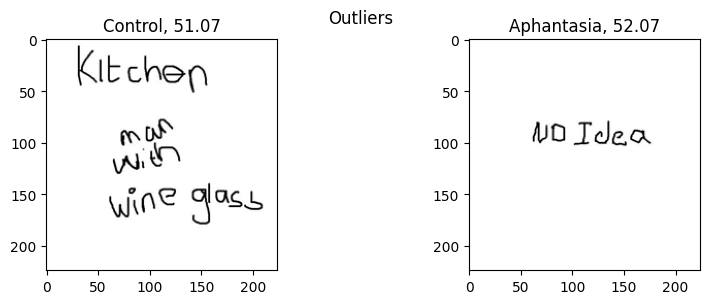

In [ ]:
outlier1 = similarities_df[similarities_df.subject_id == 145].iloc[0]
outlier2 = similarities_df[similarities_df.subject_id == 195].iloc[0]

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].imshow(np.array(outlier1['kitchen_mem_drawing']))
axes[0].set_title(f"{outlier1['treatment']}, {round(outlier1['kitchen_mem']*100,2)}")
axes[1].imshow(np.array(outlier2['kitchen_mem_drawing']))
axes[1].set_title(f"{outlier2['treatment']}, {round(outlier2['kitchen_mem']*100,2)}")
fig.suptitle('Outliers')

### Modeling

In [ ]:
# Impute missing variables with column mean
X_nodraw = similarities_df[all_cols]
col_means = X_nodraw.mean()
X_nodraw = X_nodraw.fillna(col_means)

In [ ]:
X = X_nodraw.reset_index(drop=True)
y = np.array(similarities_df['treatment'])

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# Scale Variables
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [ ]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [ ]:
def fit_model(mod, model_name, scale = False):
  kf = KFold(n_splits=5, shuffle=True, random_state=29)
  results = {
      'accuracy': [],
      'precision': [],
      'recall': [],
      'f1': []
  }

  for train_index, test_index in kf.split(X):
    if scale:
      X_train, X_test = X_scaled[train_index], X_scaled[test_index]
      y_train, y_test = y[train_index], y[test_index]
    else:
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y[train_index], y[test_index]

    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)

    results['accuracy'].append(accuracy_score(y_test, y_pred))
    results['precision'].append(precision_score(y_test, y_pred, pos_label='Aphantasia'))
    results['recall'].append(recall_score(y_test, y_pred, pos_label='Aphantasia'))
    results['f1'].append(f1_score(y_test, y_pred, pos_label='Aphantasia'))

  for metric, res in results.items():
    results[metric] = round(np.mean(res)* 100,2)
  df = pd.json_normalize(results)
  df.index = [model_name]
  return df

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier(random_state = 29)
forest_res = fit_model(forest_model, 'Random Forest',scale = False)

In [ ]:
from sklearn.linear_model import LogisticRegression
# Logistic Regression Model
log_model = LogisticRegression(penalty ='elasticnet', solver='saga', l1_ratio=0.5, max_iter=10000)
log_res = fit_model(log_model, 'Logistic Regression', scale = True)

In [ ]:
from sklearn.svm import SVC
# SVM Model
svm_model = SVC(kernel='rbf')
svm_res = fit_model(svm_model,'Support Vector Machine', scale = True)

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
# Decision Tree
tree_model = DecisionTreeClassifier(max_depth=2)
tree_res = fit_model(tree_model, 'Decision Tree', scale = False)

#### Results
The decision tree performed the best with the highest F1 score (71.13) and accuracy of 63.48%.

However, overall the models didn't do too well at predicting aphantasia from the similarity scores. The ViT CLIP model didn't do well at getting the right features as we saw with the outliers that had higher similarity scores than expected. There weren't any big differences between the 2 groups seen in the 3D scatter plot as well.

Performance could be improved by incorporating the demographic data.

In [ ]:
pd.concat([forest_res, log_res, svm_res, tree_res])

accuracy  precision  recall     f1
Random Forest              60.87      64.66   68.38  65.60
Logistic Regression        61.74      65.88   70.94  66.14
Support Vector Machine     60.87      62.02   81.63  69.24
Decision Tree              63.48      63.52   82.91  71.13

### ANOVA



In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
onlysim_df = similarities_df[['treatment', 'kitchen_mem',	'kitchen_percep',	'bedroom_mem',
                              'bedroom_percep',	'livingroom_mem',	'livingroom_percep']]

In [ ]:
melted_df = pd.melt(onlysim_df, id_vars='treatment', var_name = 'feature', value_name = 'Similarity_score')
melted_df[['room', 'type']] = melted_df['feature'].str.split('_', expand=True)
melted_df.drop(['feature'], axis = 1, inplace = True)

In [ ]:
formula = 'Similarity_score ~ C(treatment) + C(room) + C(type) + C(treatment):C(room) + C(treatment):C(type) + C(room):C(type)'
model = ols(formula, data=melted_df).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

#### Results
The results from the ANOVA show significant effects for all main effects. This does not match the results of the original paper's ANOVA when they looked at the number of objects drawn. They found no significance in the main effect for treatment. The significance in the interaction effect between treatment and type (memory/perception) was an important finding in the paper and this mathces. my results.

This analysis was done to see if the patterns found in the paper could be found using a pretrained image transformer model. A limitation of this is that the model was trained on a broad range of images. A better approach would be to fine tune a model specifically on drawings.

The paper looked more in depth into particular parts of the drawings. They used crowdsourcing to precisely measure characteristics of the drawings:

* Quantified the amount of text used to label objects in drawings
* Quantified size and location accuracy of objects drawn
* Counted number of correctly drawn objects and incorrectly drawn objects

In [ ]:
print(round(anova_results,3))

                      sum_sq     df        F  PR(>F)
C(treatment)           0.024    1.0    9.646   0.002
C(room)                0.595    2.0  120.066   0.000
C(type)                0.364    1.0  147.184   0.000
C(treatment):C(room)   0.007    2.0    1.443   0.237
C(treatment):C(type)   0.019    1.0    7.650   0.006
C(room):C(type)        0.040    2.0    8.010   0.000
Residual               1.634  660.0      NaN     NaN
